In [13]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sensors import mse, dict2vect, vect2dict
import scipy
from scipy.sparse import linalg
from multiprocess import Pool 
import heapq
from tqdm.notebook import tqdm

In [14]:
def speed_prediction(G, labelled_flows, lamb=1e-6, x0=None):
    '''
        Speed prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    line_G = nx.line_graph(G)
    
    A = nx.adjacency_matrix(line_G)
    f0 = []
    
    A.data = A.data / np.repeat(np.add.reduceat(A.data, A.indptr[:-1]), np.diff(A.indptr))
   
    U = []
    L = []
    i = 0
    j = 0
    index = {}
    for e in line_G.nodes():
        if e in labelled_flows:
            f0.append(labelled_flows[e])
            L.append(i)
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    PUL = A[np.ix_(U, L)]
    f0 = np.array(f0)
    b = PUL.dot(f0)
    PUU = A[np.ix_(U, U)]
    A = scipy.sparse.identity(PUU.shape[0])-PUU   
    res = linalg.lsmr(A, b, damp=lamb, x0=x0)
    x = res[0]
    
    pred_flows = {}

    for e in G.edges:
        if e in labelled_flows:
            pred_flows[e] = labelled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
            
    return pred_flows, res[0]

In [15]:
def synthetic_speeds(G):
    eigs = np.linalg.eig(nx.laplacian_matrix(nx.line_graph(G).to_undirected(), nodelist=nx.line_graph(G).nodes()).toarray())
    order = np.argsort(eigs[0])
    
    vals = 1e8 * eigs[1][:,-1]
    speeds = {}
    for i, v in enumerate(nx.line_graph(G).nodes()):
        speeds[v] = vals[i]
    return speeds

## Traffic Networks

In [16]:
def read_tntp_graph(filename):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ")
    flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
    speeds = synthetic_speeds(G)
    return G, flows, speeds

In [17]:
def flow_weighted_error(flows):
    def evaluate(pred, labels):
        err = 0
        for k, v in labels.items():
            err += (flows[k] * (v - pred[k])) ** 2
        return err
    
    return evaluate

In [18]:
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def flow_weighted_corr(G, flows):
    return lambda preds, labels: corr(dict2vect(G, preds), dict2vect(G, labels), dict2vect(G, flows))

In [19]:
def err(G, sensors, labels, i, error=mse):
    preds = speed_prediction(G, {s: labels[s] for s in sensors[:i]})[0]
    return error(preds, labels)

In [57]:
import random

def choose_sensors(G, labeled_edges, evaluate=mse, k=None, lazy=True, cores=8, debug=False):
    if k == None:
        k = G.number_of_edges()
        
    line_G = nx.line_graph(G)
    
    # Choose sensors
    sensors, current = None, float("inf")
    for i in range(int(len(labeled_edges) / 10)):
        candidates = random.sample(list(labeled_edges.keys()), k)
        error = evaluate(speed_prediction(G, {s: labeled_edges[s] for s in candidates})[0], labeled_edges)
        if error < current:
            sensors = candidates
            current = error
    
    pred, x0 = speed_prediction(G, {s: labeled_edges[s] for s in sensors})
    current = evaluate(pred, labeled_edges)

    old = float("inf")
    iteration = 0
    
    while abs(old - current) > 1e-5 and iteration < 10:
        old = current
        
        if debug:
            print("iteration {} current error {}".format(iteration, current))
        
        for i in range((len(sensors))):
            # Move sensor i to a more optimal placement
            subgraph = nx.ego_graph(line_G, sensors[i], 1)
            candidates = random.sample(list(subgraph.nodes()), min(10, subgraph.number_of_nodes()))
            for e in candidates:
                if e not in sensors and e in labeled_edges:
                    new_sensors = sensors[:i] + [e] + sensors[i+1:]
                    pred, res = speed_prediction(G, {s: labeled_edges[s] for s in new_sensors}, x0=x0)
                    new_err = evaluate(pred, labeled_edges)
                    if new_err < current:
                        current = new_err
                        sensors = new_sensors
                        x0 = res
                
        if debug:
            print("end of iteration {} improvement {}".format(iteration, old - current))
        iteration += 1
    return sensors

In [21]:
from sklearn.cluster import SpectralClustering

def spectral_clustering_speeds(G, k):
    '''
        Graph should be undirected.
        Node ids should be integers starting from 0.
    '''
    line_graph = nx.line_graph(G.to_undirected(), create_using=nx.Graph())
    
    A = nx.to_numpy_array(line_graph)
    sc = SpectralClustering(n_clusters=k, assign_labels='discretize', affinity='precomputed', random_state=0).fit(A)
    membership = sc.labels_
    nodes = list(line_graph.nodes())
    selected = []
    
    for i in range(k):
        part = np.argwhere(np.array(membership) == i).ravel()

        #selecting a random node in the partition
        if len(part) > 0:
            selected.append(np.random.choice(part))
        else:
            selected.append(np.random.choice(list(set(range(len(membership))) - set(selected))))
                
    return [nodes[u] for u in selected]

In [99]:
from sensors import choose_sensors_random

def plot_speed_results(G, flows, speeds, ratio, ax, title="", xlabel=False, ylabel=False, legend=False, samples=50, overall_sensors=None, debug=False):
    k = int(G.number_of_edges() * ratio)
    fwe = flow_weighted_error(flows)
    fwcorr = flow_weighted_corr(G, flows)
    
    random_sensors = choose_sensors_random(G, k)
    random_corr, greedy_corr, cluster_corr = {0: 0}, {0: 0}, {0: 0}
    
    if not overall_sensors:
        overall_sensors = {}
        
    for j in tqdm(range(1, samples + 1)):
        i = int(k * j / samples)
        
        cluster_sensors = spectral_clustering_speeds(G, i)
        if i not in overall_sensors.keys():
            greedy_sensors = choose_sensors(G, speeds, k=i, evaluate=fwe, debug=debug)
            overall_sensors[i] = greedy_sensors
        else:
            greedy_sensors = overall_sensors[i]
        
        random_corr[i] = max(err(G, random_sensors, speeds, i, error=fwcorr), 0)
        greedy_corr[i] = max(err(G, greedy_sensors, speeds, i, error=fwcorr), 0)
        cluster_corr[i] = max(err(G, cluster_sensors, speeds, i, error=fwcorr), 0)
    
    ax.plot([k / G.number_of_edges() for k in greedy_corr.keys()], greedy_corr.values(), "b", label="Greedy",
           linewidth=3)
    ax.plot([k / G.number_of_edges() for k in random_corr.keys()], random_corr.values(), "black", label="Random",
           linewidth=3, linestyle="dashed")
    ax.plot([k / G.number_of_edges() for k in cluster_corr.keys()], cluster_corr.values(), "darkgreen", label="Spectral Clustering",
           linewidth=3)
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)
    
    return overall_sensors

In [78]:
Berlin = nx.from_pandas_edgelist(pd.read_csv("data/Berlin-Tiergarten/berlin-tiergarten_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
EMA = nx.from_pandas_edgelist(pd.read_csv("data/Eastern-Massachusetts/EMA_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
LA = nx.from_pandas_edgelist(pd.read_csv("out/small.results.csv"), source="edge_from", target="edge_to")

In [94]:
LA.number_of_nodes(), LA.number_of_edges()

(1190, 1212)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


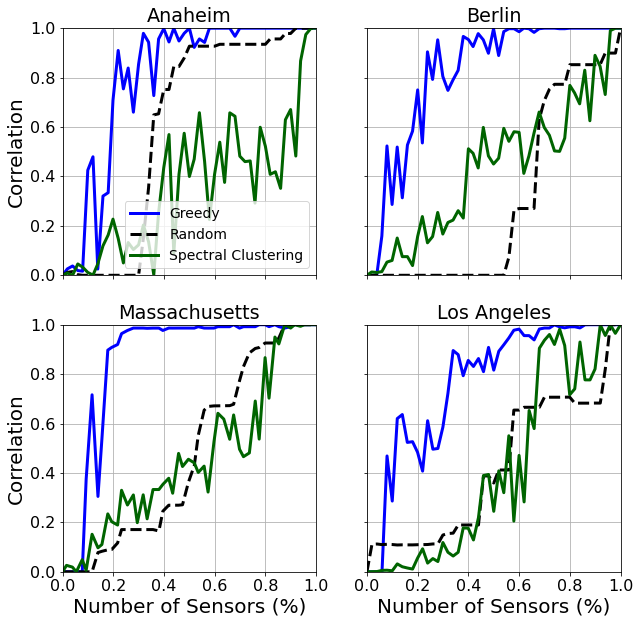

In [100]:
import matplotlib

matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sensors["Anaheim"] = plot_speed_results(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), 1, ax[0][0], samples=50, 
                                        ylabel=True, legend=True, title="Anaheim", overall_sensors=sensors["Anaheim"])
sensors["Berlin"] = plot_speed_results(Berlin, {e: 1 for e in Berlin.edges()}, synthetic_speeds(Berlin), 1, ax[0][1], samples=50, 
                                        title="Berlin", overall_sensors = sensors["Berlin"])
sensors["EMA"] = plot_speed_results(EMA, {e: 1 for e in EMA.edges()}, synthetic_speeds(EMA), 1, ax[1][0], samples=50, 
                                        xlabel=True, ylabel=True, title="Massachusetts", overall_sensors=sensors["EMA"])
sensors["LA"] = plot_speed_results(LA, {e: 1 for e in LA.edges()}, synthetic_speeds(LA), 1, ax[1][1], samples=50, 
                                        xlabel=True, title="Los Angeles", overall_sensors=sensors["LA"])
plt.savefig("results/synthetic_speeds.pdf")

In [ ]:
import json

with open("data/Anaheim/anaheim_nodes.geojson") as f:
    features = json.loads(f.read())["features"]

coords = {}
for feat in features:
    coords[feat["properties"]["id"]] = feat["geometry"]["coordinates"]

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw(G, coords, node_size=2, edge_color = ["green" if e in greedy_sensors[:50] else "black" for e in G.edges()],
       width = [5 if e in greedy_sensors[:50] else 1 for e in G.edges()])

In [ ]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw(G, coords, node_size=2, edge_color = [flows[e] for e in G.edges()])

In [ ]:
preds = speed_prediction(G, {s: speeds[s] for s in greedy_sensors[:50]})
fwcorr(preds, speeds)